<h1>Linear Regression</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.decomposition import PCA
from scipy import stats
import warnings
from sklearn.feature_selection import RFECV
warnings.filterwarnings('ignore')

Loading the data, label encoding and standardizing

In [6]:
data = pd.read_csv('../data/final_spotify_tracks.csv')
data.set_index(['title'], inplace=True)
data.head()

,artist,top genre,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",Train,POP,3.693075,78.0,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83
Love The Way You Lie,Eminem,HIPHOP,44.814807,94.0,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82
TiK ToK,Kesha,POP,6.410236,81.0,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80
Bad Romance,Lady Gaga,POP,17.680180,89.0,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79
Just the Way You Are,Bruno Mars,POP,31.020064,93.0,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78


Since linear regression can work only with numeric data, we need to encode the variables artist and top genre. I am using LabelEncoder for variable encoding, one hot encoding would produce a large number of columns so it is not very suitable.

In [7]:
data[['artist', 'top genre']] = data[['artist', 'top genre']].apply(LabelEncoder().fit_transform)
data.head()

,artist,top genre,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",200,4,3.693075,78.0,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83
Love The Way You Lie,58,3,44.814807,94.0,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82
TiK ToK,103,4,6.410236,81.0,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80
Bad Romance,108,4,17.680180,89.0,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79
Just the Way You Are,26,4,31.020064,93.0,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78


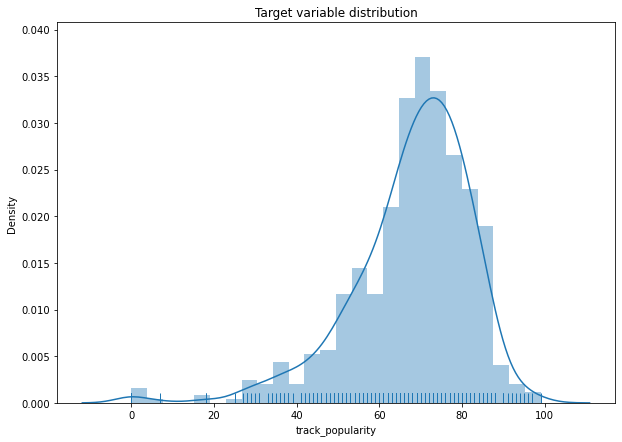

In [8]:
plt.figure(figsize=(10,7))
sns.distplot(data['track_popularity'], kde=True, rug=True)
plt.title('Target variable distribution')
plt.show()

The target varaible is a bit skewed, but not highly non-normal.

Inspecting between variable dependencies. Most important ones are with the target variable track_popularity

In [19]:
X, Y = data.drop(['track_popularity'], axis=1), data['track_popularity']
X = X.fillna(X.median())

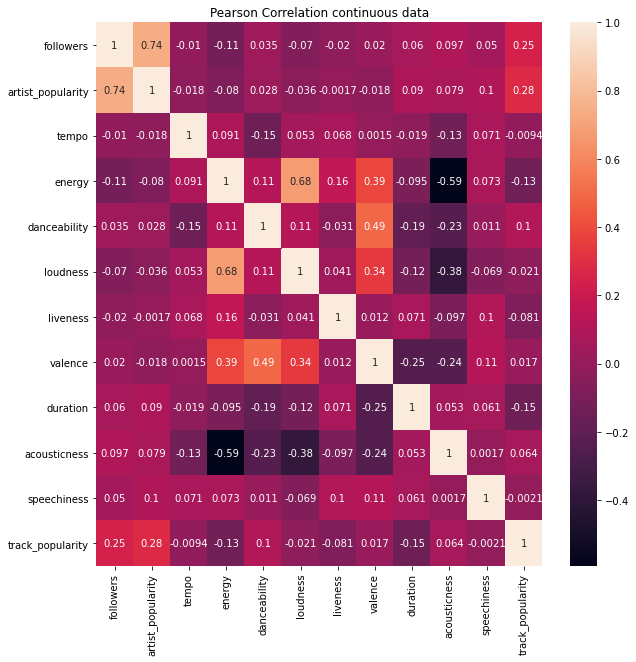

In [10]:
plt.figure(figsize=(10,10))
sns.heatmap(data[data.columns.drop(['artist', 'top genre', 'year'])].corr(), annot=True)
plt.title('Pearson Correlation continuous data')
plt.show()

The target variable track_popularity has a low correlation with all of the other attributes. The highest correlations are with followers and artist_popularity, but they are still low.

Let's visualize these dependencies.

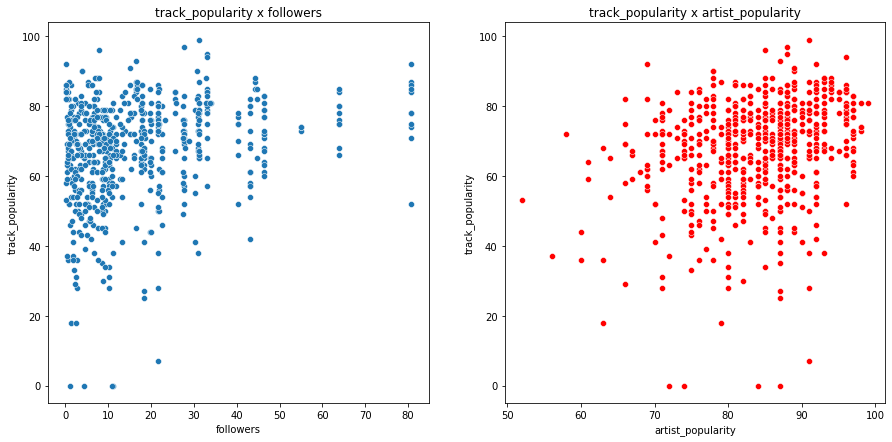

In [11]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.scatterplot(x=data['followers'], y=data['track_popularity'], ax=plt.gca())
plt.title('track_popularity x followers')
plt.subplot(1,2,2)
sns.scatterplot(x=data['artist_popularity'], y=data['track_popularity'], ax=plt.gca(), color='red')
plt.title('track_popularity x artist_popularity')
plt.show()

Plot of the estimated univariate regression line of each of the continuous features with respect to the target

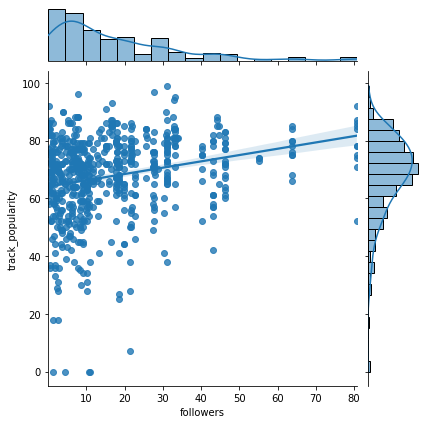

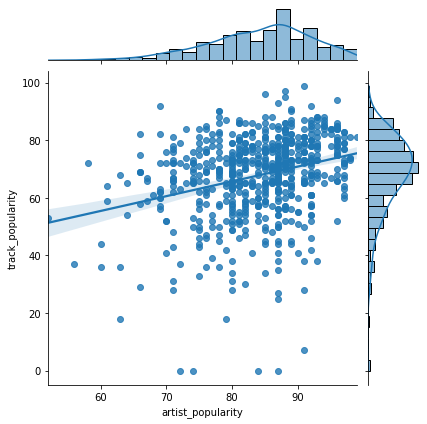

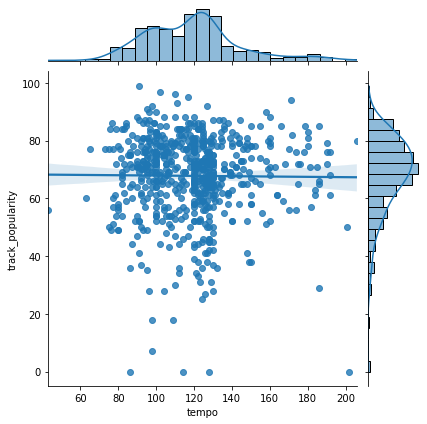

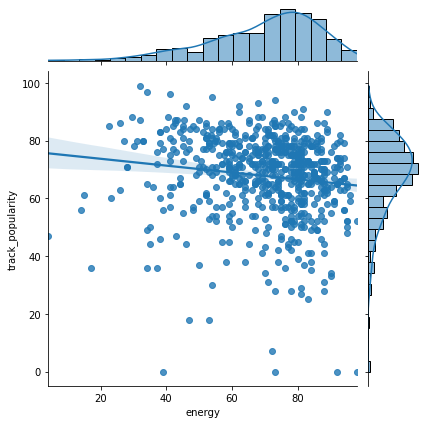

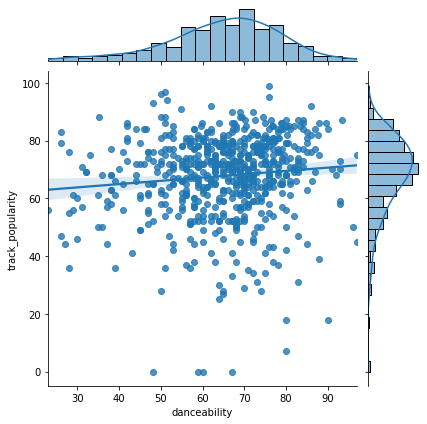

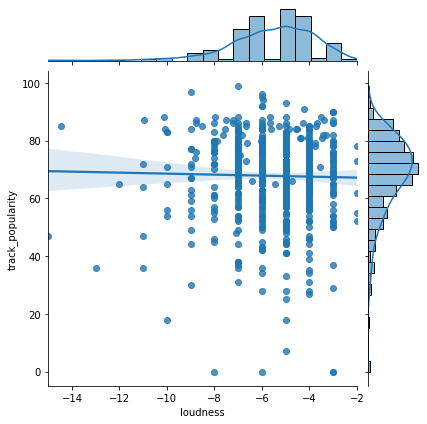

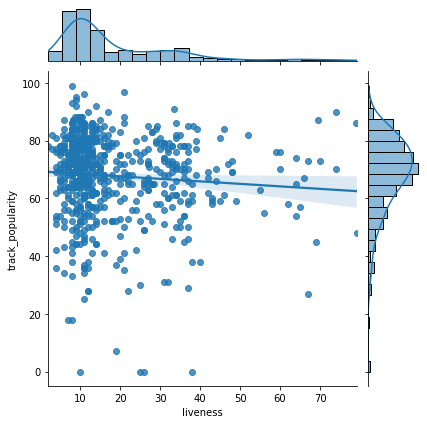

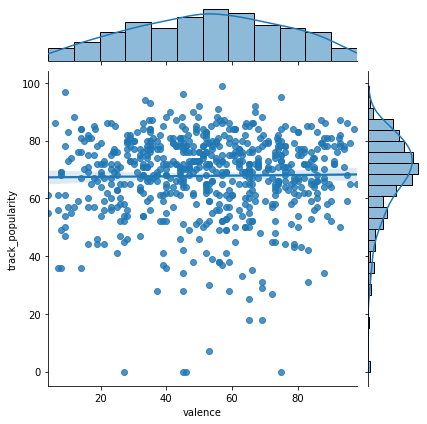

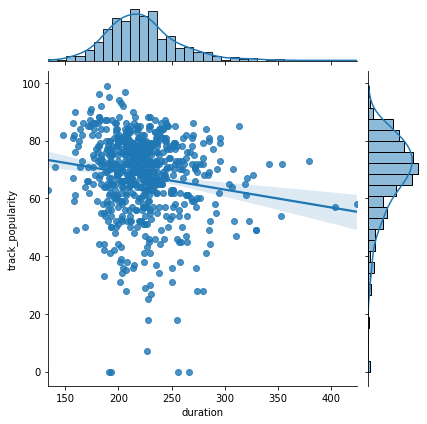

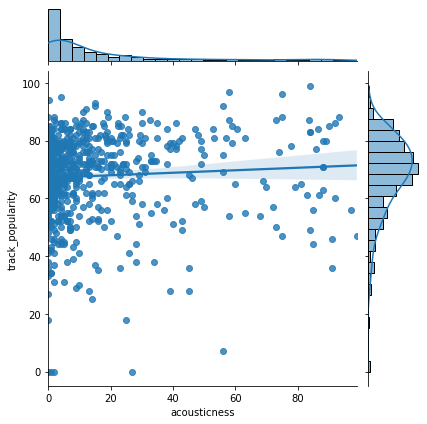

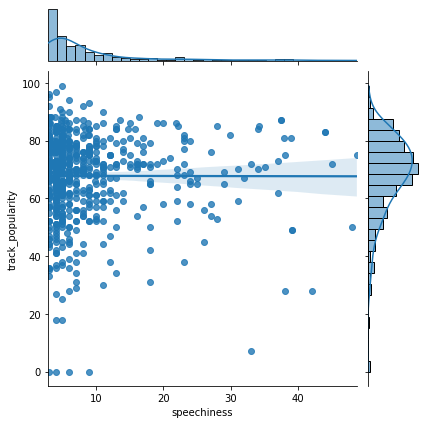

In [12]:
for feature in X.columns.drop(['year', 'top genre', 'artist']):
  sns.jointplot(x=X[feature], y=Y, kind='reg')

We can see that most of the other variables have almost no correlation with the target, indicated by a line that is almost constant.

<h3>1. Ordinary Linear Regression</h3>

In [13]:
def cross_validation_regression(X, Y, model): #cross validation prediction, 5 fold cv
  predicted = []
  actual = []
  folds = KFold(n_splits=5, shuffle=True, random_state=0)

  for train_ind, test_ind in folds.split(X):
    X_train = X.iloc[train_ind]
    Y_train = Y.iloc[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y.iloc[test_ind]
    model.fit(X_train, Y_train)
    predicted_vals = model.predict(X_test)
    predicted.extend(predicted_vals)
    actual.extend(Y_test.to_list())

  return predicted, actual

In [14]:
def rfe_algorithm_base(estimator, X, Y, step=1, cv=5, score='neg_mean_squared_error'):
  rfe = RFECV(estimator, step=step, cv=cv, scoring=score, n_jobs=3).fit(X, Y)
  mask = rfe.support_
  selected_features = []
  for i, column in enumerate(X.columns):
    if mask[i]:
      selected_features.append(column)
  cv_score = np.mean(rfe.grid_scores_)

  data_dict = {}
  data_dict['selected_features'] = selected_features
  data_dict['neg_mae_score_cv'] = cv_score  
  results = pd.DataFrame(data=data_dict)

  return results

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, 
    Y,
    test_size = 0.2,
    random_state=0
)

I am standardizing the data since linear regression expects a normal distribution. It might be more suitable for the algorithm than minmax scaling.

In [21]:
features_x = X.columns

In [22]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

In [23]:
linear = LinearRegression()
linear.fit(X_train, Y_train)

LinearRegression()

In [24]:
coeff_lr = pd.DataFrame(linear.coef_,features_x,columns=['Coefficient'])
coeff_lr

,Coefficient
artist,1.431004
top genre,-0.955996
followers,1.140861
artist_popularity,3.444942
year,3.759758
tempo,0.457265
energy,-2.336063
danceability,0.387172
loudness,2.466283
liveness,-0.484625


Plot the predicitons against the actual targets.

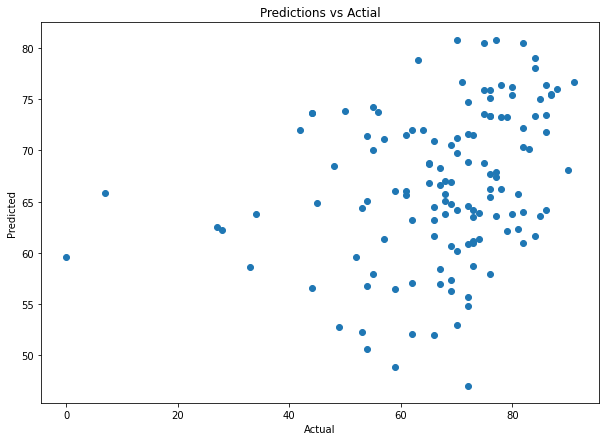

In [25]:
y_pred = linear.predict(X_test)
plt.figure(figsize=(10,7))
plt.scatter(Y_test,y_pred)
plt.title('Predictions vs Actial')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

The errors are not very good. We saw that the correlations of the features with respect to the target variable were low, seems like the linear combination of features also has a low predictive capabilities for the model.

Plot of the error with respect tot the target variable.

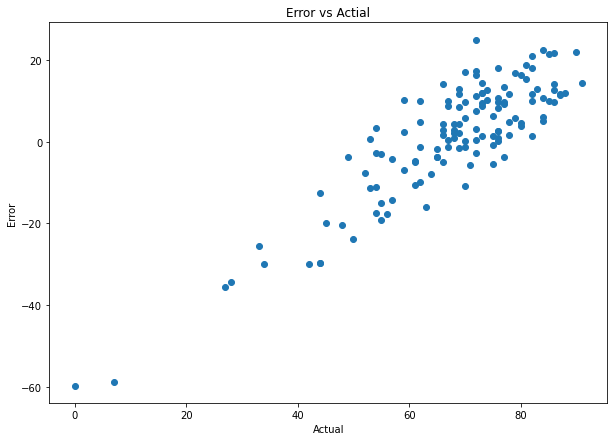

In [26]:
y_pred = linear.predict(X_test)
plt.figure(figsize=(10,7))
plt.scatter(Y_test, np.subtract(Y_test, y_pred))
plt.title('Error vs Actial')
plt.xlabel('Actual')
plt.ylabel('Error')
plt.show()

Errors seem to be larger for larger values of the target.

In [27]:
def print_metrics(Y_test, Y_pred):
  print(f'Mean squared error: {mean_squared_error(Y_test, Y_pred)}')
  print(f'Mean absolute error: {mean_absolute_error(Y_test, Y_pred)}')
  print(f'Root mean squared error: {np.sqrt(mean_squared_error(Y_test, Y_pred))}')
  print(f'R2 score: {r2_score(Y_test, Y_pred)}')

In [28]:
print_metrics(Y_test, y_pred)

Mean squared error: 216.82405091203114
Mean absolute error: 10.951503265702907
Root mean squared error: 14.72494655039641
R2 score: 0.05295440038509647


The errors are pretty high and the r2 score is low. We should have in mind that the target values are not scaled and have a mean value of around 75. Maybe basis function expansion and regularization can fix this.

Plot of the error distribution.

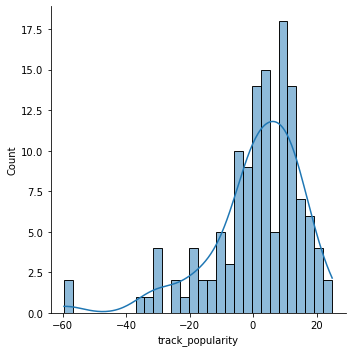

In [29]:
sns.displot((Y_test-y_pred),bins=30, kde=True)
plt.show()

The error distribution is a bit left skewed, we have some outliers in the errors, but the median is around 0. For the outliers, the model predicts a high value of popularity which turns out to be lower for approximately 60.

In [30]:
import statsmodels.api as sm

In [31]:
feature_names = ['constant']
feature_names.extend(features_x)

Perform T-test for coefficients of the features. The null hypothesis is that the coefficient is 0, the alternative is that it is different than 0.

In [32]:
X_train_2 = sm.add_constant(X_train)
X_test_2 = sm.add_constant(X_test)
est = sm.OLS(Y_train, X_train_2)
mod = est.fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     11.71
Date:                Wed, 23 Jun 2021   Prob (F-statistic):           1.34e-23
Time:                        11:17:59   Log-Likelihood:                -2050.3
No. Observations:                 521   AIC:                             4131.
Df Residuals:                     506   BIC:                             4194.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         67.8004      0.551    123.161      0.0

If we work with a p-value of 0.05, then the significant coefficients are X1, X4, X5, X7, X9 and X12.

The features that have nonzero coefficients are given above. From them, energy and duration have a negative effect on track_popularity if the other features' values are fixed. The other significant features have a positive effect on the target, for fixed values.

In [38]:
X = pd.DataFrame(X, columns=features_x)

In [39]:
results = rfe_algorithm_base(linear, X, Y) 
selected_features = results['selected_features']
selected_features

0    artist_popularity
1                 year
2               energy
3             loudness
Name: selected_features, dtype: object

Since the variables interact in some way, just eliminating the predictors that have a non-significant coefficient is not enough. At each step, after removing a variable, we should further inspect how the significance of the other variables is changed. For that reason I am using recursive feature elimination with 5-fold cv to do this.

In [40]:
results

,selected_features,neg_mae_score_cv
0,artist_popularity,-205.197823
1,year,-205.197823
2,energy,-205.197823
3,loudness,-205.197823


In [43]:
X

,artist,top genre,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness
0,1.597363,0.154848,-0.827182,-0.798903,-1.736250,-0.916258,1.189816,0.148301,0.868802,-0.762723,1.220972,-0.169320,0.164486,-0.597187
1,-0.766443,-1.167708,1.594705,1.254011,-1.736250,-1.318992,1.433017,0.748477,0.305306,2.656913,0.517290,1.173615,0.396218,1.935460
2,-0.017349,0.154848,-0.667153,-0.413981,-1.736250,0.010033,0.885815,0.823499,1.432299,0.869376,0.825151,-0.665622,-0.252631,0.735785
3,0.065883,0.154848,-0.003404,0.612476,-1.736250,-0.030241,1.372217,0.373367,0.868802,-0.762723,0.825151,2.107831,-0.716095,-0.597187
4,-1.299131,0.154848,0.782256,1.125704,-1.736250,-0.432976,0.885815,-0.076764,0.305306,-0.685004,-0.406293,-0.052543,-0.623402,-0.597187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,-0.150522,-1.167708,0.007054,1.510625,1.730926,-1.443719,-0.780109,-1.044547,-0.951291,1.257971,-1.338672,0.497360,0.901394,1.535569
648,-1.548829,0.154848,2.717207,1.510625,1.730926,2.376704,-1.485392,-0.399359,-0.628971,1.584391,0.064295,0.165889,0.317429,-0.573193
649,-0.400219,2.799961,-1.029366,-1.055517,1.730926,-1.770015,-1.345551,-1.397150,-2.560638,-0.537338,0.358961,-0.412012,3.297502,0.589158
650,-0.833029,0.154848,0.456863,1.382318,1.730926,1.096088,0.910136,-0.024249,1.006296,-0.591742,0.983479,-0.845780,-0.652601,-0.521207


Visualize the values of the significant coefficients

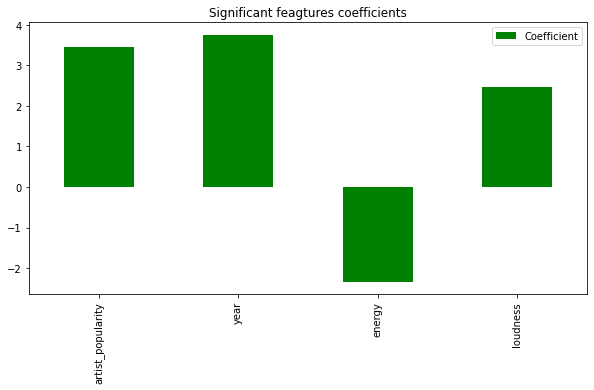

In [44]:
plt.figure(figsize=(10,5))
coeff_lr.iloc[[3, 4, 6, 8]].plot.bar(ax=plt.gca(), color='green')
plt.title('Significant feagtures coefficients')
plt.show()

Year has the largest positive contribution to the target, whereas energy has the largest negative contribution for fixed values of the other features. This means that in general songs in the recent years are more popular, and more energic songs are less popular.

In [46]:
linear.fit(X_train[:, [3, 4, 6, 8]], Y_train)
y_pred_significant = linear.predict(X_test[:, [3, 4, 6, 8]])
print_metrics(Y_test, y_pred_significant)

Mean squared error: 207.71312771413946
Mean absolute error: 10.780890643059893
Root mean squared error: 14.412256163215371
R2 score: 0.09274915418062146


Using only the significant features we get a result which is a bit better, but not much. This might be due to the error that presented by a nonzero coefficient for irrelevant attributes.

<b>Cross validation 5-Fold scores</b>

In [47]:
predicted_lin, actual_lin = cross_validation_regression(X, Y, linear)

In [48]:
print_metrics(actual_lin, predicted_lin)

Mean squared error: 174.87486772364332
Mean absolute error: 9.831542219441484
Root mean squared error: 13.224026154074384
R2 score: 0.16020136312851063


The scores are a bit better with cross validation. Maybe the former results are due to the randomness of the split.

<h3>2. Linear Regression with Basis Function Expansion</h3>

Adding features with a maximum degree of 2

In [49]:
poly2 = PolynomialFeatures(degree=2)
X_poly2 = poly2.fit_transform(X)

In [50]:
X_train_poly2, X_test_poly2, Y_train_poly2, Y_test_poly2 = train_test_split(
    X_poly2,
    Y,
    test_size = 0.2,
    random_state = 0
)

In [51]:
linear.fit(X_train_poly2, Y_train_poly2)
coeff_lr = pd.DataFrame(linear.coef_, columns=['Coefficient'])
coeff_lr

,Coefficient
0,5.151655e-16
1,6.945737e-01
2,3.843192e-02
3,2.167494e+00
4,1.433356e+00
...,...
115,-1.834792e-01
116,-3.739215e-01
117,-2.215080e-01
118,-1.903382e-01


Too many coefficients to keep track of.

Plot the predictions against the actual values

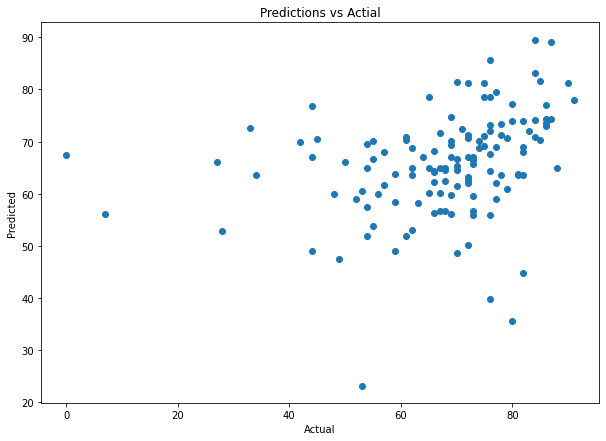

In [52]:
y_pred = linear.predict(X_test_poly2)
plt.figure(figsize=(10,7))
plt.scatter(Y_test_poly2,y_pred)
plt.title('Predictions vs Actial')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [53]:
print_metrics(Y_test_poly2, y_pred)

Mean squared error: 238.71500089433323
Mean absolute error: 11.121201684639603
Root mean squared error: 15.450404554390582
R2 score: -0.04266104340411836


Adding polynomial features with degree 2 makes the model's performance even worse. This may be due to overfitting and the curse of dimensionality.

Plot of the error distribution with polynomial features.

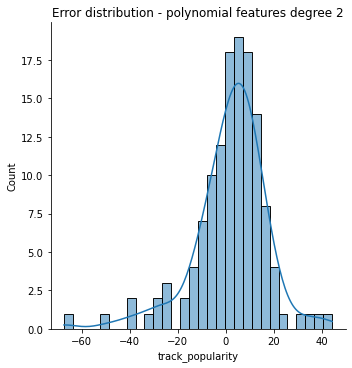

In [54]:
sns.displot((Y_test_poly2-y_pred),bins=30, kde=True)
plt.title('Error distribution - polynomial features degree 2')
plt.show()

<b>Cross validation scores</b>

In [55]:
predicted_lin_poly2, actual_lin_poly2 = cross_validation_regression(pd.DataFrame(X_poly2), Y, linear)

In [56]:
print_metrics(actual_lin_poly2, predicted_lin_poly2)

Mean squared error: 215.29768132212956
Mean absolute error: 10.898842832254386
Root mean squared error: 14.67302563625272
R2 score: -0.03392043493435293


We can see that the errors of the regression with polynomial features degree 2 are way worse than with the linear features.

<h3>3. Lasso Regression (L1 Regularization)
</h3>

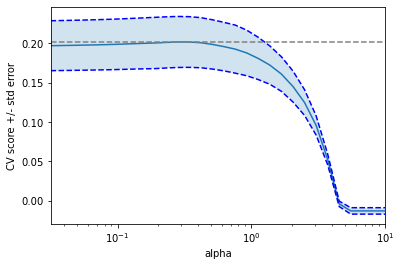

In [57]:
lasso = Lasso(random_state=0, max_iter=10000)
alphas = np.logspace(-1.5, 1, 30)

parameters = [{'alpha': alphas}]
n_folds = 5

model = GridSearchCV(lasso, parameters, cv=n_folds, refit=False)
model.fit(X_train, Y_train)
scores = model.cv_results_['mean_test_score']
scores_std = model.cv_results_['std_test_score']
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.show()

From the plot we can see that the best value for alpha is around 0.1 but a bit less.

In [58]:
lasso = Lasso(alpha=0.05, random_state=0, max_iter=10000)
lasso.fit(X_train, Y_train)
coeff_lasso = pd.DataFrame(lasso.coef_, data.columns.drop('track_popularity'), columns=['Coefficient'])
coeff_lasso

,Coefficient
artist,1.372909
top genre,-0.898713
followers,1.116205
artist_popularity,3.409248
year,3.715089
tempo,0.394234
energy,-2.095355
danceability,0.408598
loudness,2.319759
liveness,-0.455470


The coefficients are a bit smaller than for the ordinary linear regression, acousticness is zero but this is expected since Lasso has an apriori belief that most of the coefficients will be zero.

Plot of the coefficient values for Lasso.

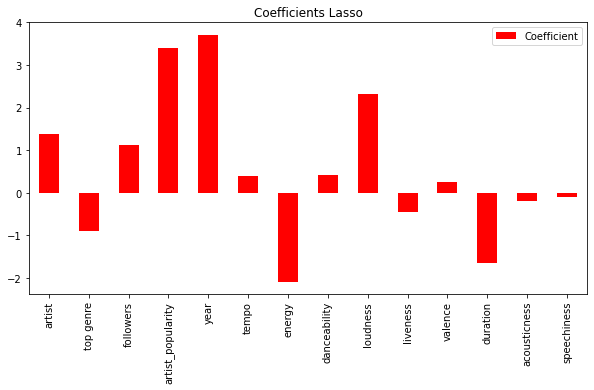

In [59]:
plt.figure(figsize=(10,5))
coeff_lasso.plot.bar(color='red', ax=plt.gca())
plt.title('Coefficients Lasso')
plt.show()

Energy and Duration are again the features which have a negative value on the target for fixed values of the other variables.

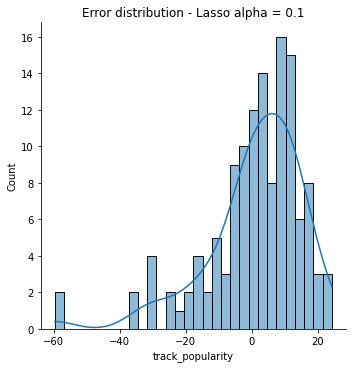

In [60]:
sns.displot((Y_test-lasso.predict(X_test)),bins=30, kde=True)
plt.title('Error distribution - Lasso alpha = 0.1')
plt.show()

In [61]:
print_metrics(Y_test, lasso.predict(X_test))

Mean squared error: 215.6174196140979
Mean absolute error: 10.900310812319537
Root mean squared error: 14.683917039199653
R2 score: 0.058224732971627224


Lasso show simillar performance to the ordinary linear regression. Although there is not a significant difference, it is a bit better compared to linear regression with all features, but worse than lr for selected features.

<b>Cross validation scores</b>

In [62]:
lasso_preds, lasso_actual = cross_validation_regression(pd.DataFrame(X), Y, lasso)

In [63]:
print_metrics(lasso_actual, lasso_preds)

Mean squared error: 174.7986477958368
Mean absolute error: 9.823763187318656
Root mean squared error: 13.221143966988516
R2 score: 0.16056739280623145


Metrics on the cross validation a better performance than on the heldout data, but are almost the same as for ordinary linear regression on the cross validation

<h3>4. Lasso and Basis Function Expansion</h3>

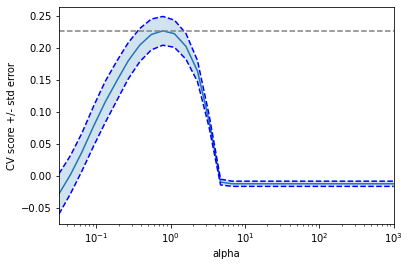

In [64]:
lasso = Lasso(random_state=0, max_iter=10000)
alphas = np.logspace(-1.5, 3, 30)

parameters = [{'alpha': alphas}]
n_folds = 5

model = GridSearchCV(lasso, parameters, cv=n_folds, refit=False)
model.fit(X_train_poly2, Y_train_poly2)
scores = model.cv_results_['mean_test_score']
scores_std = model.cv_results_['std_test_score']
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.show()

From the plot we can see that the best score is achieved around alpha of value 1.

In [65]:
lasso = Lasso(alpha=1, random_state=0, max_iter=10000)
lasso.fit(X_train_poly2, Y_train_poly2)

Lasso(alpha=1, max_iter=10000, random_state=0)

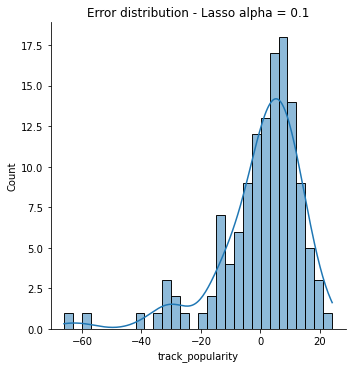

In [66]:
sns.displot((Y_test_poly2-lasso.predict(X_test_poly2)),bins=30, kde=True)
plt.title('Error distribution - Lasso alpha = 0.1')
plt.show()

In [67]:
print_metrics(Y_test_poly2, lasso.predict(X_test_poly2))

Mean squared error: 204.19255865529763
Mean absolute error: 10.11686054021552
Root mean squared error: 14.289596168377106
R2 score: 0.10812632023435065


The R2 score is higher but that may be due to the large number of features added to the model wiht polynomial features. Thus, we cannot conclude that this model performs better.

In [68]:
lasso_poly_preds, lasso_poly_actual = cross_validation_regression(pd.DataFrame(X_poly2), Y, lasso)

In [69]:
print_metrics(lasso_poly_preds, lasso_poly_actual)

Mean squared error: 169.08478275094615
Mean absolute error: 9.593003883452488
Root mean squared error: 13.003260466165635
R2 score: -5.207186843061941


Again this scores have not improved with adding polynomial features with respect to Lasso with only linear features.

<h3>5. Ridge Regression (L2 Regularization)</h3>

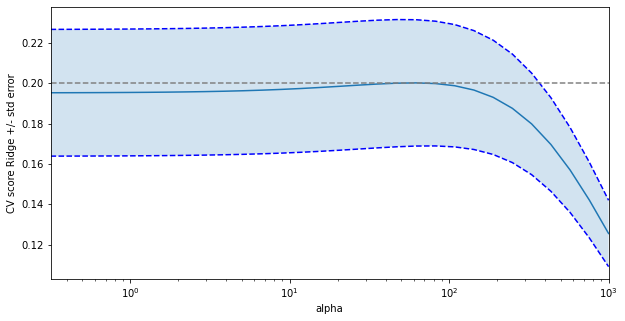

In [70]:
ridge = Ridge(random_state=0, max_iter=10000)
alphas = np.logspace(-0.5, 3, 30)

parameters = [{'alpha': alphas}]
n_folds = 5
plt.figure(figsize=(10,5))
model = GridSearchCV(ridge, parameters, cv=n_folds, refit=False)
model.fit(X_train, Y_train)
scores = model.cv_results_['mean_test_score']
scores_std = model.cv_results_['std_test_score']
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score Ridge +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.show()

From the plot we can see that the best value for aplha is around 10 to 20.

In [71]:
ind = -1
for i, sc in enumerate(scores):
  if sc == np.max(scores):
    ind = i
alpha = alphas[ind]
alpha

62.10169418915616

In [72]:
ridge = Ridge(alpha=62.2, random_state=0, max_iter=10000)
ridge.fit(X_train, Y_train)
coeff_ridge = pd.DataFrame(ridge.coef_, data.columns.drop('track_popularity'), columns=['Coefficient'])
coeff_ridge

,Coefficient
artist,1.282505
top genre,-0.864164
followers,1.386325
artist_popularity,2.925411
year,3.372153
tempo,0.399622
energy,-1.574044
danceability,0.541623
loudness,1.782749
liveness,-0.510769


The coefficients for Ridge are smaller than the ordinary Linear regression, but there are no zero coefficients.

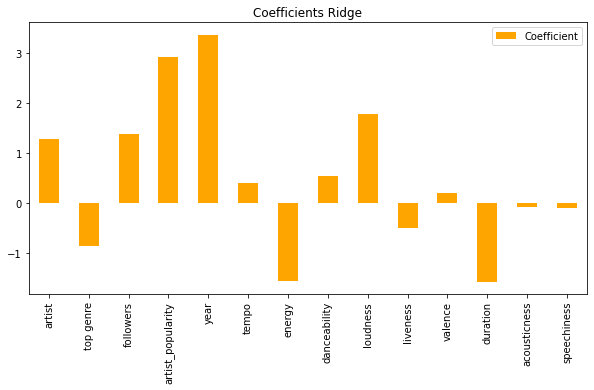

In [73]:
plt.figure(figsize=(10,5))
coeff_ridge.plot.bar(color='orange', ax=plt.gca())
plt.title('Coefficients Ridge')
plt.show()

The same can be said about the coefficients with Ridge as for Lasso and ordinary linear regression. Except in this case the magnitude of the coefficients is larger.

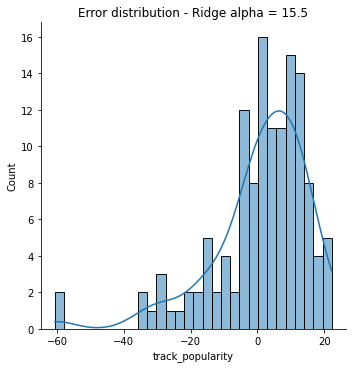

In [74]:
sns.displot((Y_test-ridge.predict(X_test)),bins=30, kde=True)
plt.title('Error distribution - Ridge alpha = 15.5')
plt.show()

In [75]:
print_metrics(Y_test, ridge.predict(X_test))

Mean squared error: 212.29233445484772
Mean absolute error: 10.778469596402156
Root mean squared error: 14.570255126621761
R2 score: 0.07274806308729931


The error is quite similar to lasso, but is a bit worse.
<br><b>Cross validation scores</b>

In [76]:
ridge_preds, ridge_actual = cross_validation_regression(pd.DataFrame(X), Y, ridge)

In [77]:
print_metrics(ridge_preds, ridge_actual)

Mean squared error: 173.4624530688802
Mean absolute error: 9.765153876234827
Root mean squared error: 13.170514533186628
R2 score: -3.5722430234197873


Again, the cross validation errors for Ridge are almost the same as for Lasso.

<h3>6. Ridge and Basis Function Expansion</h3>

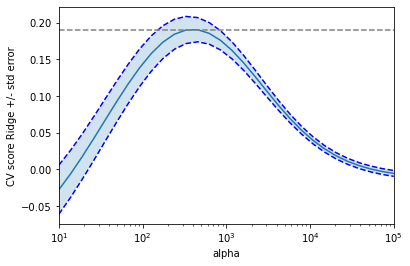

In [78]:
ridge = Ridge(random_state=0, max_iter=10000)
alphas = np.logspace(1, 5, 30)

parameters = [{'alpha': alphas}]
n_folds = 5

model = GridSearchCV(ridge, parameters, cv=n_folds, refit=False)
model.fit(X_train_poly2, Y_train_poly2)
scores = model.cv_results_['mean_test_score']
scores_std = model.cv_results_['std_test_score']
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score Ridge +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.show()

From the plot we can see that the best value for alpha is close to 1000.

In [79]:
ind = -1
for i, sc in enumerate(scores):
  if sc == np.max(scores):
    ind = i
alpha = alphas[ind]
alpha

452.03536563602404

In [80]:
ridge = Ridge(alpha=alpha, random_state=0, max_iter=10000)
ridge.fit(X_train_poly2, Y_train_poly2)

Ridge(alpha=452.03536563602404, max_iter=10000, random_state=0)

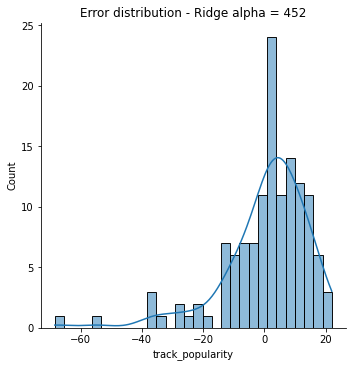

In [82]:
sns.displot((Y_test_poly2-ridge.predict(X_test_poly2)),bins=30, kde=True)
plt.title('Error distribution - Ridge alpha = 452')
plt.show()

In [83]:
print_metrics(Y_test_poly2, ridge.predict(X_test_poly2))

Mean squared error: 202.2923573926098
Mean absolute error: 10.129114643272379
Root mean squared error: 14.222951781982873
R2 score: 0.11642603254320927


<b>Cross validation errors</b>

In [84]:
ridge_preds, ridge_actual = cross_validation_regression(pd.DataFrame(X_poly2), Y, ridge)

In [85]:
print_metrics(ridge_preds, ridge_actual)

Mean squared error: 171.39203917728315
Mean absolute error: 9.633182447221541
Root mean squared error: 13.091678241435785
R2 score: -4.278844188881663


There is no significant improvement in the errors from using polynomial features.

Since the model seems to overfit for polynomial features even of degree 2, there is no need to try for higher values. This can be seen from the large values of the regularization parameters even though the values of the variables are standardized. 

The best results were achieved with ordinary linear regression and selected features with recursive elimination of unsignificant predictors.